In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
data_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/u net/main")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


/content/drive/MyDrive/Colab Notebooks/u net/main/train/2959.jpg


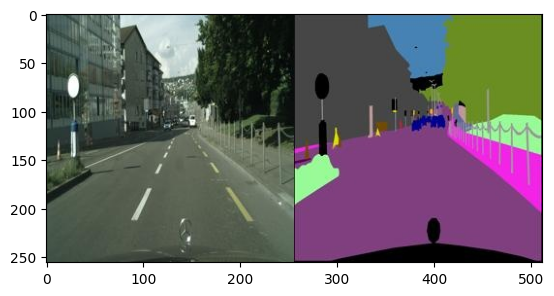

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[4])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [ ]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


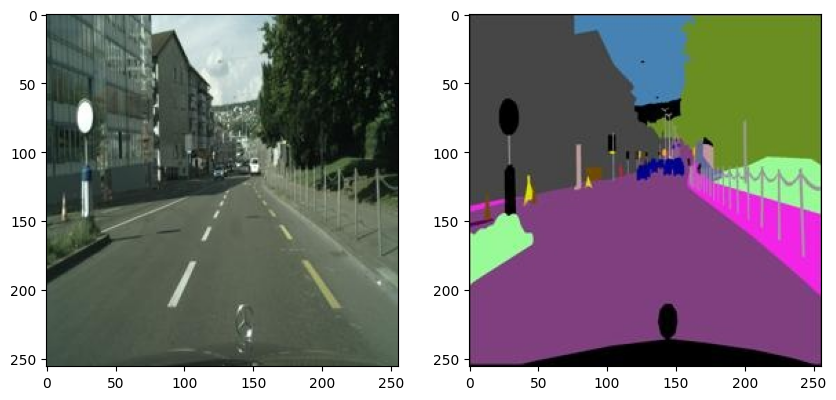

In [ ]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [ ]:
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
class CityscapeDataset(Dataset):

    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        # self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        # label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label).long()
        return cityscape, label_class

    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
dataset = CityscapeDataset(train_dir)
print(len(dataset))

2975


In [ ]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256, 3])


In [ ]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256, 3])


In [2]:
!pip install datasets -qq
!pip install evaluate -qq
!pip install albumentations -qq
!pip install git+https://github.com/huggingface/transformers.git -qq
# We will use this to push our trained model to HF Hub
!pip install huggingface_hub -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00


In [3]:
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)
import evaluate
from huggingface_hub import notebook_login

In [5]:
train = load_dataset("scene_parse_150", "instance_segmentation", split="train")
validation = load_dataset("scene_parse_150", "instance_segmentation", split="validation")
test = load_dataset("scene_parse_150", "instance_segmentation", split="test")

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train

Dataset({
    features: ['image', 'annotation'],
    num_rows: 20210
})

[INFO] Displaying a random image and its annotation...


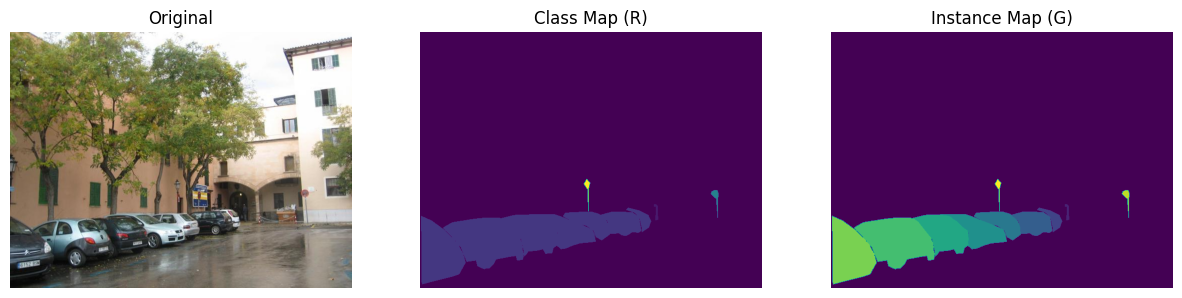

In [6]:
print("[INFO] Displaying a random image and its annotation...")
index = random.randint(0, len(train))
# Using the random index grab the corresponding datapoint
# from the training dataset
image = train[index]["image"]
image = np.array(image.convert("RGB"))
annotation = train[index]["annotation"]
annotation = np.array(annotation)
# Plot the original image and the annotations
plt.figure(figsize=(15, 5))
for plot_index in range(3):
    if plot_index == 0:
        # If plot index is 0 display the original image
        plot_image = image
        title = "Original"
    else:
        # Else plot the annotation maps
        plot_image = annotation[..., plot_index - 1]
        title = ["Class Map (R)", "Instance Map (G)"][plot_index - 1]
    # Plot the image
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")

In [7]:
processor = MaskFormerImageProcessor(
    reduce_labels=True,
    size=(512, 512),
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:429: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
from transformers import MaskFormerConfig
config = MaskFormerConfig.from_pretrained("facebook/maskformer-swin-base-coco")
config

MaskFormerConfig {
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "depths": [
      2,
      2,
      18,
      2
    ],
    "drop_path_rate": 0.3,
    "embed_dim": 128,
    "hidden_size": 1024,
    "image_size": 384,
    "in_channels": 3,
    "model_type": "swin",
    "num_heads": [
      4,
      8,
      16,
      32
    ],
    "out_features": [
      "stage4"
    ],
    "out_indices": [
      4
    ],
    "path_norm": true,
    "pretrain_img_size": 384,
    "window_size": 12
  },
  "ce_weight": 1.0,
  "cross_entropy_weight": 1.0,
  "decoder_config": {
    "max_position_embeddings": 1024,
    "model_type": "detr",
    "scale_embedding": false
  },
  "dice_weight": 1.0,
  "fpn_feature_size": 256,
  "id2label": {
    "0": "person",
    "1": "bicycle",
    "2": "car",
    "3": "motorcycle",
    "4": "airplane",
    "5": "bus",
    "6": "train",
    "7": "truck",
    "8": "boat",
    "9": "traffic light",
    "10": "fire hydrant",
    "11": 

In [9]:
model_name = "facebook/maskformer-swin-base-ade"
# Get the MaskFormer config and print it
config = MaskFormerConfig.from_pretrained(model_name)
print("[INFO] displaying the MaskFormer configuration...")
print(config)

[INFO] displaying the MaskFormer configuration...
MaskFormerConfig {
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "depths": [
      2,
      2,
      18,
      2
    ],
    "drop_path_rate": 0.3,
    "embed_dim": 128,
    "hidden_size": 1024,
    "image_size": 384,
    "in_channels": 3,
    "model_type": "swin",
    "num_heads": [
      4,
      8,
      16,
      32
    ],
    "out_features": [
      "stage4"
    ],
    "out_indices": [
      4
    ],
    "path_norm": true,
    "pretrain_img_size": 384,
    "window_size": 12
  },
  "ce_weight": 1.0,
  "cross_entropy_weight": 1.0,
  "decoder_config": {
    "max_position_embeddings": 1024,
    "model_type": "detr",
    "scale_embedding": false
  },
  "dice_weight": 1.0,
  "fpn_feature_size": 256,
  "id2label": {
    "0": "wall",
    "1": "building",
    "2": "sky",
    "3": "floor",
    "4": "tree",
    "5": "ceiling",
    "6": "road, route",
    "7": "bed",
    "8": "window ",
    "9": "g

In [10]:
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt


--2023-09-20 09:17:18--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [text/plain]
Saving to: ‘instanceInfo100_train.txt’

instanceInfo100_tra 100%[===================>]   3.24K  --.-KB/s    in 0s      

2023-09-20 09:17:18 (31.9 MB/s) - ‘instanceInfo100_train.txt’ saved [3313/3313]



In [11]:
# Get a modified version of the id2label and label2id
data = pd.read_csv(
    "/content/instanceInfo100_train.txt",
    sep="\t",
    header=0,
    on_bad_lines="skip",
)
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
label2id = {v: k for k, v in id2label.items()}
# Edit MaskFormer config labels
config.id2label = id2label
config.label2id = label2id

In [12]:
data

,Idx,Object Names,Unnamed: 2,#Inst.,#Pix. per Inst.(*1e3)
0,1,bed,2189,49.06,NaN
1,2,windowpane,8833,10.57,NaN
2,3,cabinet,6727,12.59,NaN
3,4,person,21441,3.47,NaN
4,5,door,4694,11.82,NaN
...,...,...,...,...,...
95,96,bulletin board,282,5.02,NaN
96,97,radiator,199,5.93,NaN
97,98,glass,1487,0.67,NaN
98,99,clock,843,1.25,NaN


In [13]:
model = MaskFormerForInstanceSegmentation(config)
# Replace the randomly initialized model with the pre-trained model weights
base_model = MaskFormerModel.from_pretrained(model_name)
model.model = base_model

In [14]:
# Define the configurations of the transforms specific
# to the dataset used
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
# Build the augmentation transforms
train_val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])
class ImageSegmentationDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        # Initialize the dataset, processor, and transform variables
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        # Return the number of datapoints
        return len(self.dataset)

    def __getitem__(self, idx):
        # Convert the PIL Image to a NumPy array
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        # Get the pixel wise instance id and category id maps
        # of shape (height, width)
        instance_seg = np.array(self.dataset[idx]["annotation"])[..., 1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[..., 0]
        class_labels = np.unique(class_id_map)
        # Build the instance to class dictionary
        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})
        # Apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            (image, instance_seg) = (transformed["image"], transformed["mask"])

            # Convert from channels last to channels first
            image = image.transpose(2,0,1)
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # If the image has no objects then it is skipped
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros(
                (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
            )
        else:
            # Else use process the image with the segmentation maps
            inputs = self.processor(
                [image],
                [instance_seg],
                instance_id_to_semantic_id=inst2class,
                return_tensors="pt"
            )
            inputs = {
                k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
            }
        # Return the inputs
        return inputs
# Build the train and validation instance segmentation dataset
train_dataset = ImageSegmentationDataset(
    train,
    processor=processor,
    transform=train_val_transform
)
val_dataset = ImageSegmentationDataset(
    validation,
    processor=processor,
    transform=train_val_transform
)

In [16]:
def collate_fn(examples):
    # Get the pixel values, pixel mask, mask labels, and class labels
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_mask = torch.stack([example["pixel_mask"] for example in examples])
    mask_labels = [example["mask_labels"] for example in examples]
    class_labels = [example["class_labels"] for example in examples]
    # Return a dictionary of all the collated features
    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels
    }
# Building the training and validation dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# Set number of epochs and batch size
num_epochs = 2
for epoch in range(num_epochs):
    print(f"Epoch {epoch} | Training")
    # Set model in training mode
    model.train()
    train_loss, val_loss = [], []
    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )
        # Backward propagation
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        if idx % 50 == 0:
            print("  Training loss: ", round(sum(train_loss)/len(train_loss), 6))
        # Optimization
        optimizer.step()
    # Average train epoch loss
    train_loss = sum(train_loss)/len(train_loss)
    # Set model in evaluation mode
    model.eval()
    start_idx = 0
    print(f"Epoch {epoch} | Validation")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            # Forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )
            # Get validation loss
            loss = outputs.loss
            val_loss.append(loss.item())
            if idx % 50 == 0:
                print("  Validation loss: ", round(sum(val_loss)/len(val_loss), 6))
    # Average validation epoch loss
    val_loss = sum(val_loss)/len(val_loss)
    # Print epoch losses
    print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")

Epoch 0 | Training


  0%|          | 0/5053 [00:00<?, ?it/s]

  Training loss:  5.970171
  Training loss:  6.003806
  Training loss:  5.114344
  Training loss:  4.63884
  Training loss:  4.382509
  Training loss:  4.209283
  Training loss:  4.075192
  Training loss:  3.968693
  Training loss:  3.887926
  Training loss:  3.811456
  Training loss:  3.749005
  Training loss:  3.691648
